In [307]:
import os
import sys
sys.path.insert(0, "../")
import pandas as pd
import numpy as np
import data_processing.utils as utils
import matplotlib.pyplot as plt
import seaborn as sns
import datetime
from scipy.special import softmax

from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import NearestNeighbors
sns.set_style('whitegrid')
pd.options.mode.chained_assignment = None 

In [354]:
TEST_PATH = os.path.join(os.path.dirname(os.getcwd()), 'data_processing/test_files/')
PARTITION_SUBGRADES = "partition_subgrades_30000.csv"
FIG_PATH = os.path.join(os.path.dirname(os.getcwd()), 'figures/external_comparisons/')
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 160)

In [355]:
cat_vars_of_interest = ["term", "grade", "sub_grade", "emp_title", "emp_length", "home_ownership", "verification_status", "purpose", "addr_state", 
    "initial_list_status", "application_type", "hardship_flag", "loan_status"
]
num_vars_of_interest = list(set([
    "loan_amnt", "funded_amnt", "funded_amnt_inv", "int_rate", "zip_code", "installment", "issue_d", "annual_inc", "dti", "fico_range_low", "fico_range_high", 
    "revol_bal", "revol_util", "open_acc", "delinq_2yrs", "inq_last_6mths", "total_acc", "mths_since_last_delinq", "mths_since_last_record", "mths_since_rcnt_il",
    "last_credit_pull_d", "open_il_12m", "open_il_24m", "total_bal_il", "il_util", "open_rv_12m", "open_rv_24m", "max_bal_bc", "all_util",
    "total_rev_hi_lim", "inq_fi", "total_cu_tl", "inq_last_12m", "acc_open_past_24mths", "avg_cur_bal", "bc_open_to_buy", "bc_util", "num_accts_ever_120_pd",
    "num_actv_bc_tl", "num_actv_rev_tl", "num_bc_sats", "num_bc_tl", "num_sats", "num_il_tl", "num_op_rev_tl", "num_rev_accts", "num_rev_tl_bal_gt_0", "tot_hi_cred_lim", 
    "pct_tl_nvr_dlq", "percent_bc_gt_75", "total_bal_ex_mort", "total_bc_limit","total_il_high_credit_limit", "mths_since_last_major_derog", "mths_since_recent_bc",
    "mths_since_recent_bc_dlq", "mths_since_recent_inq", "mths_since_recent_revol_delinq"
]))

In [356]:
partition_subgrade = pd.read_csv(TEST_PATH + PARTITION_SUBGRADES)
partition_subgrade = partition_subgrade[num_vars_of_interest + cat_vars_of_interest]
partition_subgrade.reset_index(drop = True)
partition_subgrade, num_vars_of_interest, cat_vars_of_interest = utils.clean_accepted_df(partition_subgrade, numeric_cols= num_vars_of_interest, categorical_cols= cat_vars_of_interest, one_hot_threshold=30)

shared_features = ["loan_amnt", "annual_inc", "term", "fico_range_low", "fico_range_high", "delinq_2yrs", "mths_since_last_delinq"] #, "issue_d"]
nn_df_with_int_rate = partition_subgrade[shared_features]
nn_df_with_int_rate["fico"] = (partition_subgrade["fico_range_high"] + partition_subgrade["fico_range_low"]) / 2.0
nn_df_with_int_rate.drop(["fico_range_high", "fico_range_low"], axis = 1, inplace = True)
nn_df_with_int_rate["int_rate"] = partition_subgrade["int_rate"]
nn_df_with_int_rate["sub_grade"] = partition_subgrade["sub_grade"]


/home/acowlagi/.conda/envs/torch_py39/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3165: DtypeWarning: Columns (19,118) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


In [357]:
nn_df_with_int_rate.head()

,loan_amnt,annual_inc,term,delinq_2yrs,mths_since_last_delinq,fico,int_rate,sub_grade
0,1400.0,64000.0,0,0.0,133.0,702.0,12.88,11
1,5000.0,79000.0,0,0.0,133.0,667.0,13.44,12
2,6000.0,100000.0,0,1.0,15.0,697.0,7.49,3
3,4225.0,35000.0,0,2.0,18.0,727.0,14.85,14
4,15000.0,44000.0,0,0.0,47.0,687.0,5.32,0


In [358]:
cat_vars_of_interest = ["term", "grade", "sub_grade", "emp_title", "emp_length", "home_ownership", "verification_status", "purpose", "addr_state", 
    "initial_list_status", "application_type", "hardship_flag", "loan_status"
]
num_vars_of_interest = list(set([
    "loan_amnt", "funded_amnt", "funded_amnt_inv", "int_rate", "zip_code", "installment", "issue_d", "annual_inc", "dti", "fico_range_low", "fico_range_high", 
    "revol_bal", "revol_util", "open_acc", "delinq_2yrs", "inq_last_6mths", "total_acc", "mths_since_last_delinq", "mths_since_last_record", "mths_since_rcnt_il",
    "last_credit_pull_d", "open_il_12m", "open_il_24m", "total_bal_il", "il_util", "open_rv_12m", "open_rv_24m", "max_bal_bc", "all_util",
    "total_rev_hi_lim", "inq_fi", "total_cu_tl", "inq_last_12m", "acc_open_past_24mths", "avg_cur_bal", "bc_open_to_buy", "bc_util", "num_accts_ever_120_pd",
    "num_actv_bc_tl", "num_actv_rev_tl", "num_bc_sats", "num_bc_tl", "num_sats", "num_il_tl", "num_op_rev_tl", "num_rev_accts", "num_rev_tl_bal_gt_0", "tot_hi_cred_lim", 
    "pct_tl_nvr_dlq", "percent_bc_gt_75", "total_bal_ex_mort", "total_bc_limit","total_il_high_credit_limit", "mths_since_last_major_derog", "mths_since_recent_bc",
    "mths_since_recent_bc_dlq", "mths_since_recent_inq", "mths_since_recent_revol_delinq"
]))

In [395]:
EXTERNAL_DATA_PATH = "eart_60m_clean.csv"
external_data = pd.read_csv(TEST_PATH + EXTERNAL_DATA_PATH,  index_col = 0)

# Stuff relevant if using samples from LendingClub, not external
# external_data = external_data[num_vars_of_interest + cat_vars_of_interest]
# external_data = external_data.reset_index(drop = True)
# external_data.head()
# external_data, num_vars_of_interest, cat_vars_of_interest = utils.clean_accepted_df(external_data, numeric_cols= num_vars_of_interest, categorical_cols= cat_vars_of_interest, one_hot_threshold=30)

# shared_features = ["loan_amnt", "annual_inc", "term", "fico_range_low", "fico_range_high", "delinq_2yrs", "mths_since_last_delinq", "int_rate", "sub_grade"] #, "issue_d"]
# external_data = external_data[shared_features]
# external_data["fico"] = (external_data["fico_range_high"] + external_data["fico_range_low"]) / 2.0
# external_data.drop(["fico_range_high", "fico_range_low"], axis = 1, inplace = True)
# external_data["int_rate"] = external_data["int_rate"]
# external_data["sub_grade"] = external_data["sub_grade"]
# external_data = external_data[["loan_amnt", "annual_inc", "term", "delinq_2yrs", "mths_since_last_delinq", "fico", "int_rate",  "sub_grade"]]


external_data.columns = ["int_rate", "loan_amnt", "fico", "drop", "annual_inc", "drop", "delinq_2yrs", "mths_since_last_delinq", "drop", "issue_d", "drop", "drop"]
external_data.drop("drop", axis = 1, inplace= True)
external_data["term"] = 1 if "60" in EXTERNAL_DATA_PATH else 0
max_mths = nn_df_with_int_rate["mths_since_last_delinq"].max()
external_data["mths_since_last_delinq"] = external_data["mths_since_last_delinq"].apply(lambda x: max_mths if x == -1 else x)
external_data = external_data[external_data["fico"] > 640]
external_data = external_data[external_data["int_rate"] > 0]
external_data = external_data[["loan_amnt", "annual_inc", "term", "delinq_2yrs", "mths_since_last_delinq", "fico", "int_rate"]]
# external_data["issue_d"] = (pd.to_datetime(external_data["issue_d"]) - datetime.datetime(2018,1,1)).dt.days.astype('float64')
external_data.head()

,loan_amnt,annual_inc,term,delinq_2yrs,mths_since_last_delinq,fico,int_rate
494,26243.22,70249.537285,1,0.0,133.0,725.0,28.0
958,20528.59,39102.076190,1,0.0,133.0,646.0,28.0
994,19728.20,39883.725632,1,0.0,133.0,678.0,28.0
1011,24033.49,33815.965829,1,0.0,133.0,645.0,28.0
2537,13862.56,43272.205128,1,0.0,133.0,693.0,28.0


In [396]:
scaler = StandardScaler().fit(nn_df_with_int_rate.iloc[:, :-2])
normalized_int = scaler.transform(nn_df_with_int_rate.iloc[:, :-2])
int_rate_corrs = (nn_df_with_int_rate.corr()['int_rate']).values[:-2]

num_neighbors = 5
nn = NearestNeighbors(n_neighbors = num_neighbors, metric = "mahalanobis", metric_params= {'V': np.diag(1/int_rate_corrs)*np.cov(normalized_int.T)*np.diag(1/int_rate_corrs)})

In [397]:
nn.fit(normalized_int)

NearestNeighbors(metric='mahalanobis',
                 metric_params={'V': array([[  13.36572993,    0.        ,    0.        ,    0.        ,
          -0.        ,    0.        ],
       [   0.        ,  187.5724795 ,    0.        ,    0.        ,
          -0.        ,    0.        ],
       [   0.        ,    0.        ,    3.07467325,   -0.        ,
          -0.        ,   -0.        ],
       [   0.        ,    0.        ,   -0.        , 1247.20787274,
          -0.        ,   -0.        ],
       [  -0.        ,   -0.        ,   -0.        ,   -0.        ,
         468.95760889,    0.        ],
       [   0.        ,    0.        ,   -0.        ,   -0.        ,
           0.        ,    5.98843606]])})

In [398]:
normalized_ext = scaler.transform(external_data.iloc[:,:-1])
#normalized_ext = scaler.transform(external_data.iloc[:,:-2])
ext_neighbors = nn.kneighbors(normalized_ext)

In [399]:
ext_nearest_neighbor_sub_grades = nn_df_with_int_rate["sub_grade"].iloc[ext_neighbors[1].flatten()]

sub_grade_to_int_rate = {}
sub_grades = nn_df_with_int_rate["sub_grade"].unique()

for sub_grade in sub_grades:
    sub_grade_to_int_rate[sub_grade] = nn_df_with_int_rate["int_rate"][nn_df_with_int_rate["sub_grade"] == sub_grade].mean()

ext_nearest_neighbor_int_rates = ext_nearest_neighbor_sub_grades.apply(lambda x: sub_grade_to_int_rate[x])
ext_nearest_neighbor_int_rates_weights = softmax(ext_neighbors[0], axis = 1).flatten()

In [400]:
ext_weighted_int_rates = ext_nearest_neighbor_int_rates * ext_nearest_neighbor_int_rates_weights
ext_weighted_int_rates = ext_weighted_int_rates.values.reshape((-1, num_neighbors))
ext_pred_int_rate = np.sum(ext_weighted_int_rates, axis = 1)

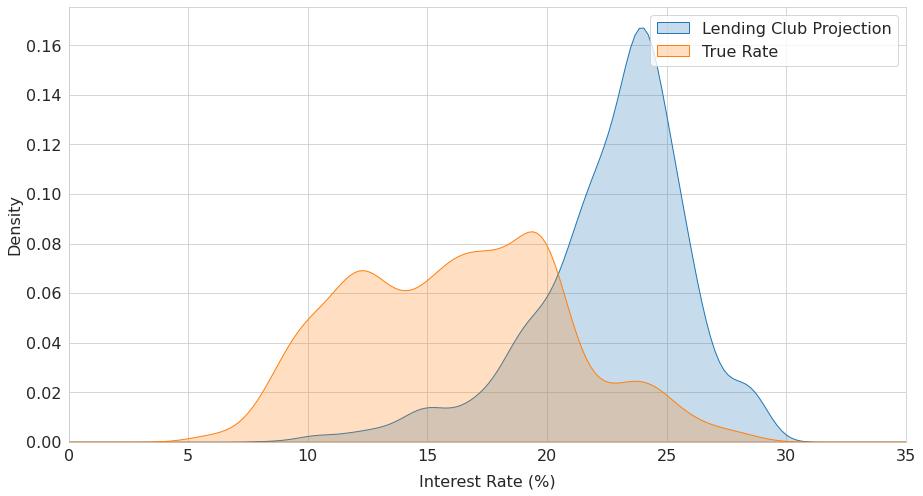

In [401]:
plt.figure(figsize=(15,8))
sns.kdeplot(ext_pred_int_rate, cut = 35, clip = (-2, 35), fill = True, label = "Lending Club Projection")
sns.kdeplot(external_data["int_rate"], cut = 35, clip = (-2, 35), fill = True, label = "True Rate")
plt.tick_params(labelsize=16)
plt.xlabel("Interest Rate (%)", fontsize = 16, labelpad= 10)
plt.legend(fontsize= 16)
plt.ylabel("Density", fontsize = 16)
plt.xlim(0, 35)
plt.savefig(FIG_PATH + "eart_60m_pdf_comps.pdf")


In [402]:
from sklearn.neighbors import KernelDensity

x_range = np.linspace(0, 35, 1000)
# instantiate and fit the KDE model
kde_pred = KernelDensity(bandwidth=0.8, kernel='gaussian')
kde_pred.fit(ext_pred_int_rate.reshape((ext_pred_int_rate.shape[0], 1)))
pred_logprob = kde_pred.score_samples(x_range.reshape((x_range.shape[0], 1)))
kde_act = KernelDensity(bandwidth=0.8, kernel='gaussian')
kde_act.fit(external_data["int_rate"].values.reshape((external_data["int_rate"].shape[0], 1)))
act_logprob = kde_act.score_samples(x_range.reshape((x_range.shape[0], 1)))
from scipy.integrate import trapz

BC = trapz(x = x_range, y=np.sqrt(np.exp(pred_logprob)*np.exp(act_logprob)))
BC

0.7257761446157888

### Testing Area

In [403]:
# Only relevant if external_data uses samples from Lending Club
# plt.scatter(ext_pred_int_rate,  external_data["int_rate"])


In [404]:
# Only relevant if external_data uses samples from Lending Club
# external_plotting_df = pd.DataFrame({'Interest Rate (%)': ext_pred_int_rate,
#                    'Residual': ext_pred_int_rate - external_data["int_rate"] })
# ax = external_plotting_df.plot.hexbin(x='Interest Rate (%)', y='Residual', gridsize=15, figsize = (15, 10),sharex=False, cmap = "Blues")
# ax.set_xlabel("Interest Rate (%)", fontsize = 16, labelpad= 10)
# ax.set_ylabel("Residual", fontsize = 16)

In [405]:
from scipy import stats
stats.ttest_ind(ext_pred_int_rate, external_data["int_rate"], alternative= "greater")

Ttest_indResult(statistic=48.28181237894089, pvalue=0.0)

In [406]:
# Only relevant if external data uses samples from LendingClub
# pred_int_rate = pd.Series(ext_pred_int_rate)
# xrange = np.linspace(-2, 35, 2000)
# for i in range(35):
#     ax = sns.kdeplot(pred_int_rate[external_data["sub_grade"] == i], cut = 35, clip = (-2, 35), fill = True)
#     print(pred_int_rate[external_data["sub_grade"] == i].std())
#     plt.xlim([-2, 35])
#     # nn_df_reset_ind["int_rate"][nn_df_reset_ind["sub_grade"] == i].plot(kind = "kde")
#     plt.axvline(x=sub_grade_to_int_rate[i], color='k', linestyle='--')
#     plt.axvline(x=pred_int_rate[external_data["sub_grade"]  == i].median(), color = 'r', linestyle='--')
#     plt.show()